In [0]:
# Installing Tensorflow 2.0
# !python3 -m pip install tensorflow==2.0.0-beta1
import warnings
warnings.filterwarnings('ignore')

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

# Make sure that we have the correct version
# Expected result: '2.0.0-beta1'
tf.__version__

'2.0.0-rc0'

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import os
import pathlib
import pandas as pd
from PIL import Image
from tensorflow.compat.v2.keras.preprocessing.image import ImageDataGenerator, load_img

## Define Constants

In [0]:
IMAGE_WIDTH = 170
IMAGE_HEIGHT = 170
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 32

## Load and preprocess data

In [114]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [115]:
import pathlib
data_root = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/')
# data_source = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data_source/')
data_source = pathlib.Path('/content/gdrive/My Drive/data/')
data_cleaned_source = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/')
data_train_path = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/train')
data_val_path = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/validation')
print(data_root)
print(data_train_path)
print(data_val_path)

/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/train
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/validation


### Utils functions

In [0]:
# This function will get all image paths and file size
def get_file_size_from_path(path):
  labels = [x.name for x in path.glob('*') if x.is_dir() and x.name.endswith('0')]
  label_names = {key:value for value, key in enumerate(sorted(labels))}
  
  all_images = [str(x) for x in path.glob('*/*') if x.parent.name in label_names]

  results = []
  for image in all_images:
    fsize = os.path.getsize(image)
    results.append([image, fsize])
  
  return results

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
  fig, axes = plt.subplots(4, 3, figsize=(12,12))
  axes = axes.flatten()
  for img, ax in zip( images_arr, axes):
      ax.imshow(img)
      ax.axis('off')
  plt.tight_layout()
  plt.show()

### Get all labels

In [117]:
labels = [x.name for x in data_source.glob('*') if x.is_dir() and x.name.endswith('0')]
label_names = {key:value for value, key in enumerate(sorted(labels))}
label_names

{'1000': 0,
 '100000': 1,
 '2000': 2,
 '20000': 3,
 '200000': 4,
 '5000': 5,
 '50000': 6,
 '500000': 7}

### Get file size from data source

In [110]:
all_images = [str(x) for x in data_source.glob('*/*') if x.parent.name in label_names and x.is_file()]

all_images_with_size = []
for image in all_images:
  print(image)
  fsize = os.path.getsize(image)
  im = Image.open(image)
  all_images_with_size.append([image, im.width, im.height, fsize])

print('total images:', len(all_images_with_size))
all_images_with_size[:10]

OSError: ignored

### Get large images

#### Create a DataFrame for all images

In [108]:
df_source_images = pd.DataFrame(all_images_with_size, columns=['filename', 'width', 'height', 'filesize'])
df_source_images.info()
df_source_images.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517 entries, 0 to 1516
Data columns (total 4 columns):
filename    1517 non-null object
width       1517 non-null int64
height      1517 non-null int64
filesize    1517 non-null int64
dtypes: int64(3), object(1)
memory usage: 47.5+ KB


,filename,width,height,filesize
1118,/content/gdrive/My Drive/data/2000/651377f5d8e...,1280,960,190290
1407,/content/gdrive/My Drive/data/200000/IMG_20190...,4608,3456,2870291
575,/content/gdrive/My Drive/data/100000/IMG_4776.jpg,1000,1000,749901
44,/content/gdrive/My Drive/data/20000/20190827_1...,5312,2988,1224701
633,/content/gdrive/My Drive/data/5000/5000_018.jpeg,600,800,65097


#### Visualize all images by file size

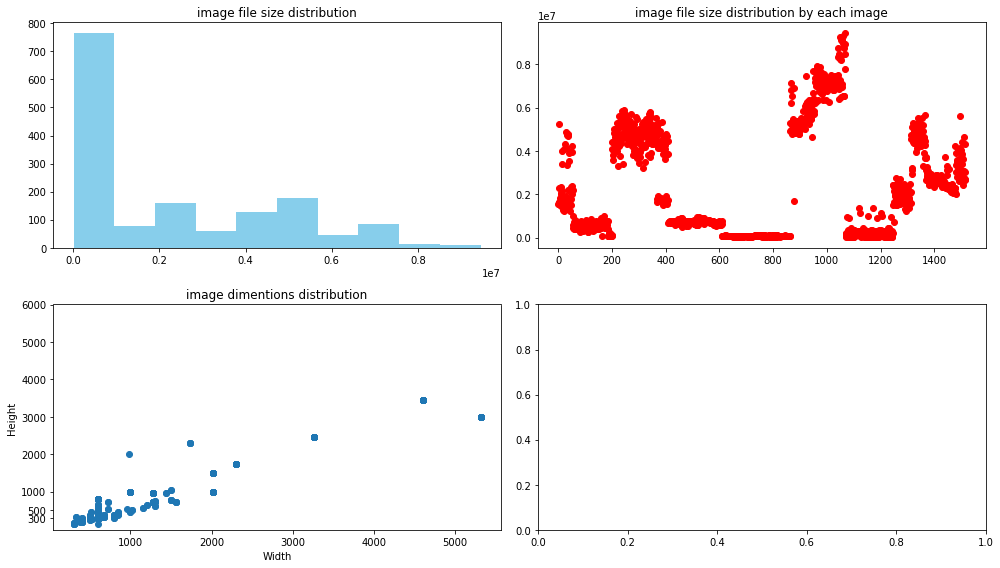

In [106]:
fig, ax = plt.subplots(2, 2 , figsize=[14, 8])

ax[0,0].hist(df_source_images.filesize, color="skyblue")
ax[0,0].set_title('image file size distribution')

ax[0,1].plot(df_source_images.filesize, 'ro')
ax[0,1].set_title('image file size distribution by each image')

ax[1,0].scatter(df_source_images.width, df_source_images.height)
ax[1,0].set_title('image dimentions distribution')
ax[1,0].set_xlabel('Width')
ax[1,0].set_ylabel('Height')
ax[1,0].set_yticks([300, 500, 1000, 2000, 3000, 4000, 5000, 6000])

plt.tight_layout()
plt.show()

Notice that there are files with large size (over 1MB), we will need to reduce these files' size.

### Resize all large images

In [107]:
# all_images = [str(x) for x in data_source.glob('*/*') if x.is_file()]

for image_path in df_source_images.filename.tolist():
    
  image = Image.open(image_path)

  # check if image is PNG
  if len(image.split()) > 3:
    #convert PNG to JPEG
    image = image.convert('RGB')
  
  # check destination folders
  if not data_cleaned_source.is_dir():
    # destination train folder is not existed, create one
    os.mkdir(data_cleaned_source)
  
  # get the file name
  image_splits = image_path.rsplit('/', 2)
  dest_folder = pathlib.Path(os.path.join(data_cleaned_source, image_splits[1]))
  
  # if destination folder not existed, then create one
  if not dest_folder.is_dir():
    os.mkdir(dest_folder)
   
  # set destination file name
  dest_filename = pathlib.Path(os.path.join(image_path.rsplit('/', 2)[-2], image_path.rsplit('/', 2)[-1]))
  # set new destination
  dest_filename = pathlib.Path(os.path.join(data_cleaned_source, dest_filename))
  
  # image resizing process
  if image.width > 500 or image.height > 500:
    # set the new dimensions
    if (image.width > image.height): # landscape image
      new_size = (int(500*(image.width/image.height)), 500 )
      
    else: # portrait image
       new_size = tuple(reversed(new_size))
     
    output = image.resize(new_size)
    
    # save all resized file to new destination
    if not dest_filename.is_file():
      output.save(dest_filename)
    
  else: # now working on the rest images
    if not dest_filename.is_file():
      image.save(dest_filename)
  
  print(dest_filename)
  print(image.width, image.height)
  print(new_size)

/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142355.jpg
5312 2988
(888, 500)
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142619.jpg
5312 2988
(888, 500)
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142209.jpg
5312 2988
(888, 500)
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142745.jpg
5312 2988
(888, 500)
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142426.jpg
5312 2988
(888, 500)
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142154.jpg
5312 2988
(888, 500)
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_det

OSError: ignored

### Train - Validation splitting

In [91]:
random.seed(42)

TRAIN_SIZE = 0.8

# check if train folder is existed or not
if not data_train_path.is_dir():
  # destination train folder is not existed, create one
  os.mkdir(data_train_path)

# check if validation folder is existed or not
if not data_val_path.is_dir():
  # destination train folder is not existed, create one
  os.mkdir(data_val_path)
    
for label in labels:
  label_path = pathlib.Path(os.path.join(data_cleaned_source, label))
  
  label_images = [image for image in label_path.glob('*') if image.is_file()]
  random.shuffle(label_images)
  label_images_total = len(label_images)
  dest_train_path = pathlib.Path(os.path.join(data_train_path, label))
  dest_val_path = pathlib.Path(os.path.join(data_val_path, label))
  
  if not dest_train_path.is_dir():
    # destination folder is not existed, create one
    os.mkdir(dest_train_path)
  
  if not dest_val_path.is_dir():
    # destination folder is not existed, create one
    os.mkdir(dest_val_path)
  
  train_total = int(label_images_total*TRAIN_SIZE)

  for index in range(0, train_total):
    shutil.copy(label_images[index], dest_train_path)
    print("copy to train folder:", label_images[index])
  
  for index in range(train_total, label_images_total):
    shutil.copy(label_images[index], dest_val_path)
    print("copy to validation folder:", label_images[index])
  
#   print(label_path)
#   print('total:', label_images_total)
#   print(label_images[train_total])
#   print('train:', i)
#   print('val:', j)

copy to train folder: /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142209.jpg
copy to train folder: /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142043.jpg
copy to train folder: /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/IMG_20190827_095211.jpg
copy to train folder: /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/IMG_4480.jpg
copy to train folder: /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_093253.jpg
copy to train folder: /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/money_detection_vnd/data/cleaned_source/20000/20190827_142102.jpg
copy to train folder: /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansi

### Plot some preprocessed images

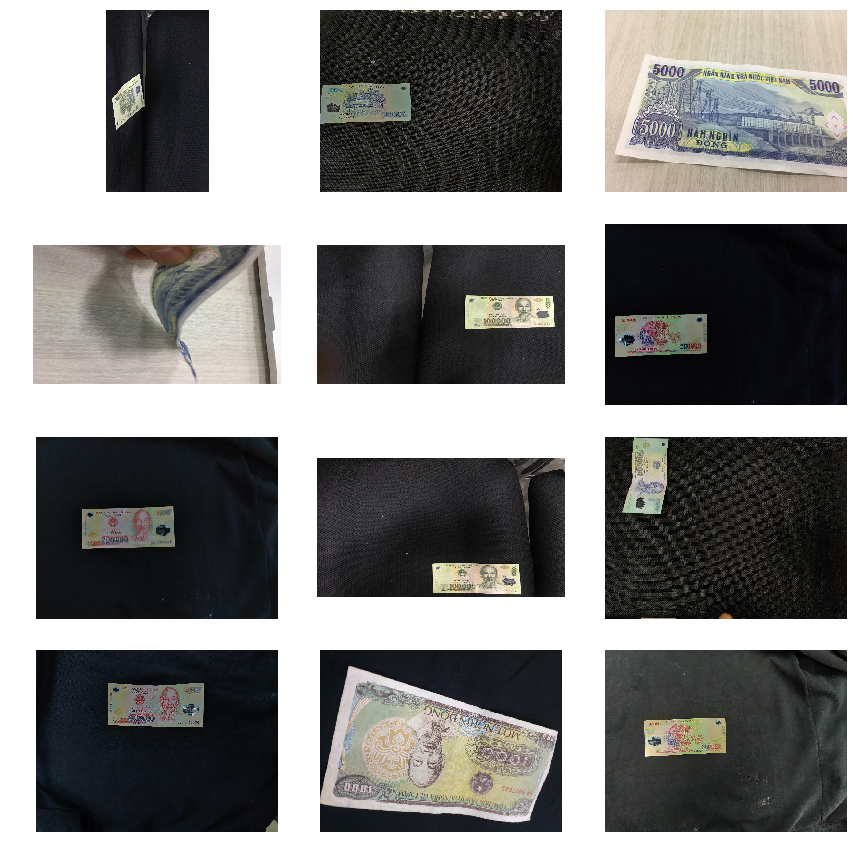

In [92]:
all_preprocessed_images = [str(x) for x in data_train_path.glob('*/*') if x.parent.name in label_names]

random.shuffle(all_preprocessed_images)

image_list = []
for image_path in all_preprocessed_images[:12]:
  image = Image.open(image_path)
  image_list.append(image)

plotImages(image_list)

## Create model

In [100]:
# print out all total number of images each label
total_train_images = 0
total_val_images = 0

for label in labels:
  label_train_path = pathlib.Path(os.path.join(data_train_path, label))
  label_val_path = pathlib.Path(os.path.join(data_val_path, label))
  label_train_images = [image for image in label_train_path.glob('*') if image.is_file()]
  label_val_images = [image for image in label_val_path.glob('*') if image.is_file()]
  total_train_images += len(label_train_images)
  total_val_images += len(label_val_images)
  print('total train images in ' + label + ':', len(label_train_images))
  print('total validation images in ' + label + ':', len(label_val_images))
  
print('total train images:', total_train_images)
print('total validation images:', total_val_images)

# Preprocess Train dataset
train_img_datagen = ImageDataGenerator(
                                        rescale=1./255
#                                         rescale=1./255,
#                                         rotation_range=45,
#                                         shear_range=0.1,
#                                         zoom_range=0.2,
#                                         horizontal_flip=True
                                      )

train_generator = train_img_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=data_train_path,
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')

# Preprocess Validation dataset
validation_img_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_img_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=data_val_path,
                                                              target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                              class_mode='binary')

total train images in 20000: 148
total validation images in 20000: 37
total train images in 50000: 180
total validation images in 50000: 45
total train images in 100000: 160
total validation images in 100000: 40
total train images in 5000: 202
total validation images in 5000: 51
total train images in 500000: 165
total validation images in 500000: 42
total train images in 2000: 70
total validation images in 2000: 18
total train images in 1000: 54
total validation images in 1000: 14
total train images in 200000: 162
total validation images in 200000: 41
total train images: 1141
total validation images: 288
Found 1141 images belonging to 8 classes.
Found 288 images belonging to 8 classes.


## Plot augmented images

In [0]:
index = np.random.randint(0, len(train_generator))
augmented_images = [train_generator[index][0][0] for i in range(15)]
plotImages(augmented_images)

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

def create_model():
  
  model = tf.keras.Sequential()

  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='softmax')) 
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#   model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [95]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 168, 168, 16)      448       
_________________________________________________________________
batch_normalization_5 (Batch (None, 168, 168, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 84, 84, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 84, 84, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 82, 82, 32)        4640      
_________________________________________________________________
batch_normalization_6 (Batch (None, 82, 82, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 41, 41, 32)       

## Train Model

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1), # learning rate decay
    ModelCheckpoint('checkpoint-model.h5', verbose=1, save_best_only=True)
]

In [99]:
epochs = 10

history = model.fit_generator(
    train_generator,
    steps_per_epoch=total_train_images // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val_images // BATCH_SIZE,
    workers=5,
    use_multiprocessing=True,
    callbacks=callbacks
)

Epoch 1/10
34/35 [============================>.] - ETA: 0s - loss: -46.7393 - accuracy: 0.1430
Epoch 00001: val_loss did not improve from -46.95804
35/35 [==============================] - 13s 384ms/step - loss: -46.9239 - accuracy: 0.1425 - val_loss: -46.9580 - val_accuracy: 0.1389
Epoch 2/10
Epoch 1/10
34/35 [============================>.] - ETA: 0s - loss: -47.0916 - accuracy: 0.1383
Epoch 00002: val_loss did not improve from -46.95804
35/35 [==============================] - 15s 414ms/step - loss: -47.1978 - accuracy: 0.1371 - val_loss: -46.9580 - val_accuracy: 0.1389
Epoch 3/10
34/35 [============================>.] - ETA: 0s - loss: -47.6010 - accuracy: 0.1374
Epoch 00003: val_loss improved from -46.95804 to -46.95804, saving model to checkpoint-model.h5
35/35 [==============================] - 16s 457ms/step - loss: -47.3903 - accuracy: 0.1407 - val_loss: -46.9580 - val_accuracy: 0.1389
Epoch 4/10
34/35 [============================>.] - ETA: 0s - loss: -45.9715 - accuracy: 0.

## Visualize training results

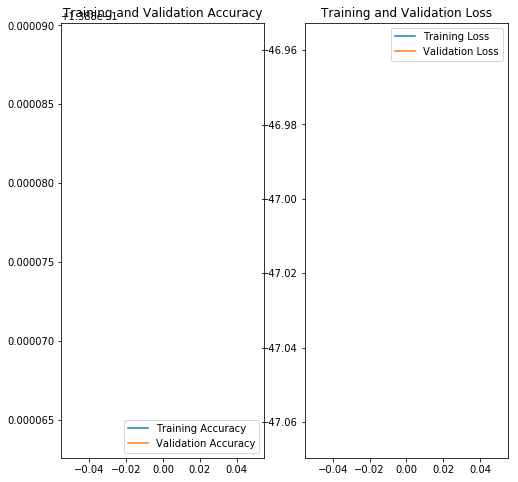

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save model

In [0]:
Save the entire model to a HDF5 file
model.save('static/models/my_model.h5')